In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2021-11-17 13:08:18.979491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 13:08:18.979529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

data_flow = pd.read_csv('./Haivoron_waterflow.csv')
replace_value = "52.8"  # avg or first row
cleared_data = data_flow.drop(["Year", "Average annual"], axis=1).fillna(replace_value).iloc[:-3]

print(cleared_data)

     Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
0   52.8  52.8  75,1  88,5    48  37,2  49,2  66,8  65,8  45,5  51,7  35,8
1   21,9  40,7   189   118  83,3  64,3  44,5  50,8  28,7    28  34,6  33,7
2     29  27,8   130  55,3  39,8  26,5  22,6  25,9  17,7  17,7  19,3  10,8
3   11,2  59,5  65,5   130  31,5  21,1    23   9,1  11,3  13,2    20    49
4   30,3  26,1  73,4   443  72,5  24,5  36,6  29,4  16,4    19  21,8  27,5
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
78  37,4  71,3   251   108  33,5  13,4  24,4  17,7  18,2  42,3  41,2  32,7
79  32,7  54,8  50,6    41  24,4  15,4  15,6  38,1  45,7  60,7  44,4  43,4
80  49,7  62,1   110    98  98,9  46,3  31,3  34,6  54,7  61,1  51,8  62,9
81  54,2  43,5  89,7   172  56,9  94,3  44,8  27,6  65,1  67,8  62,4    48
82  47,3  61,1  64,1  38,3  21,1  16,2  11,7  20,4  37,4  51,6  45,7  38,1

[83 rows x 12 columns]


In [6]:
full_data = []
for column in cleared_data.columns:
    print(f"Iteration for column {column}")
    column_data = [float(x.replace(",", ".")) for x in cleared_data[column].iloc[:-1].to_numpy().flatten().tolist()]
    full_data.extend(column_data)
    
full_data = np.array(full_data)
#Smoothing original data
kernel_size = 2
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(full_data, kernel, mode = 'same')
######
data_convolved = data_convolved.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data_convolved)

# print(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#####################################################################
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

#####################################################################
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Iteration for column Jan
Iteration for column Feb
Iteration for column Mar
Iteration for column Apr
Iteration for column May
Iteration for column Jun
Iteration for column Jul
Iteration for column Aug
Iteration for column Sep
Iteration for column Oct
Iteration for column Nov
Iteration for column Dec
659 325


2021-11-17 13:11:28.393975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-17 13:11:28.394892: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-17 13:11:28.396468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc0006): /proc/driver/nvidia/version does not exist
2021-11-17 13:11:28.457368: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-17 13:11:29.259253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimiz

Epoch 1/100
657/657 [==============================] - 5s 2ms/step - loss: 0.0298 - accuracy: 0.0015
Epoch 2/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0104 - accuracy: 0.0015
Epoch 3/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0077 - accuracy: 0.0015
Epoch 4/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0069 - accuracy: 0.0015
Epoch 5/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0068 - accuracy: 0.0015
Epoch 6/100
657/657 [==============================] - 2s 2ms/step - loss: 0.0066 - accuracy: 0.0015
Epoch 7/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0067 - accuracy: 0.0015
Epoch 8/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0066 - accuracy: 0.0015
Epoch 9/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0065 - accuracy: 0.0015
Epoch 10/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0065 - accura

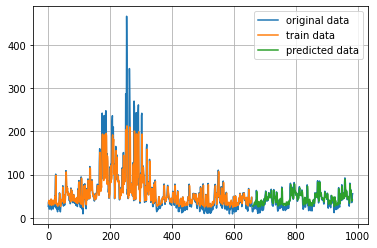

In [7]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label = 'original data')
plt.plot(trainPredictPlot, label = 'train data')
plt.plot(testPredictPlot, label = 'predicted data')
plt.legend()
plt.grid()
plt.show()